In [1]:
import itertools
import numpy as np
import pandas as pd
import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import pyemma
from pyemma.coordinates import source
from pyemma.util.contexts import settings

In [2]:
import featurize.featurize as feat_
import featurize.caller as caller

loading trajs through pyemma

In [3]:
from pyemma.coordinates import source
files = ['traj_dat/w1.xtc', 'traj_dat/w2.xtc','traj_dat/w3.xtc'] 

In [4]:
feat = pyemma.coordinates.featurizer('traj_dat/10.gro') 
feat.add_backbone_torsions() 
reader = pyemma.coordinates.source(files, features=feat) 
data_output = reader.get_output()

In [10]:
def load_trajectories(traj_files, top_file):
    """Load molecular dynamics simulation trajectories."""
    traj = md.load(traj_files, top=top_file)
    return traj

def extract_features(traj_files, top_file):
    """Extract features from trajectories."""
    tr = top_file
    feat_ = caller.feature(tr)
    reader = pyemma.coordinates.source(traj_files, features=feat_)
    return reader


In [11]:
# Load molecular dynamics simulation trajectories
traj_files = ['traj_dat/w1.xtc', 'traj_dat/w2.xtc', 'traj_dat/w3.xtc']
top_file = 'traj_dat/10.gro'
traj = load_trajectories(traj_files, top_file)

# Extract features from trajectories
reader = extract_features(traj_files, top_file)

In [12]:
n_list = []
ls = []
for item in files:
    n_list.append(md.load(item, top='traj_dat/10.gro'))
    u_ = mda.Universe('traj_dat/10.gro', item)
    ls.append(u_)
    print(item)

traj_dat/w1.xtc
traj_dat/w2.xtc
traj_dat/w3.xtc


In [34]:
universes = [mda.Universe('traj_dat/10.gro', traj_mda) for traj_mda in files]

# Define lipid and protein selections
lipid_selection = '(resname POPC DOPE SAPI)'
prot_selections = [f"(resid {i}) and (not backbone)" for i in range(1, 36)]

# Initialize contact analysis class
contact_analysis = feat_.cont()

# Run analysis for each trajectory and each protein selection
results = []
for universe in universes:
    for prot_sel in prot_selections:
        result = contact_analysis.contacts_MDA(universe, universe.select_atoms(prot_sel), universe.select_atoms(lipid_selection))
        results.append(result)

In [52]:
np.shape(results)


(105,)

In [102]:
# splits breaks it into the correct amount of trajectories
splits1 = np.array_split(results, 3)

# here we are pushing to have the whole thing reshaped
processor1 = caller.ChunkProcessor(splits1, 35)

m1 = processor1.fubar(splits1, 35)

/home/jaybraun/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [103]:
processors = [caller.ReturnInputs() for _ in range(3)]
inputs = [processor.return_inputs(m1, i, 35) for i, processor in enumerate(processors)]
new_inputs = [np.array(input).reshape(-1) for input in inputs]


(1, 1, 35, 11)
(1, 1, 35, 5)
(1, 1, 35, 11)


In [109]:
processors = [caller.ReturnInputs() for _ in range(3)]
inputs = [processor.return_inputs(m1, i, 35) for i, processor in enumerate(processors)]

(1, 1, 35, 11)
(1, 1, 35, 5)
(1, 1, 35, 11)


In [147]:
def return_inputs(m, i, n):
    return caller.ReturnInputs().return_inputs(m, i, n)

processors = [caller.ReturnInputs() for i in range(3)]
inputs = [processor.return_inputs(m1, i, 35) for i, processor in enumerate(processors)]
inputs = [x[0] for x in inputs]


(1, 1, 35, 11)
(1, 1, 35, 5)
(1, 1, 35, 11)


In [153]:
result_list = []
for i in range(3):
    arr1 = data_output[i]
    arr2 = inputs[i]
    result = np.concatenate((arr1, arr2), axis=1)
    result_list.append(result)

In [154]:
np.shape(result_list)

/home/jaybraun/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(3,)

In [155]:
tica_dev = pyemma.coordinates.tica(conts,lag=1,dim=4)
tica_out = tica_dev.get_output()
tica_concatenated = np.concatenate(tica_out)

calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

In [156]:
ls = caller.make_arr(tica_concatenated)

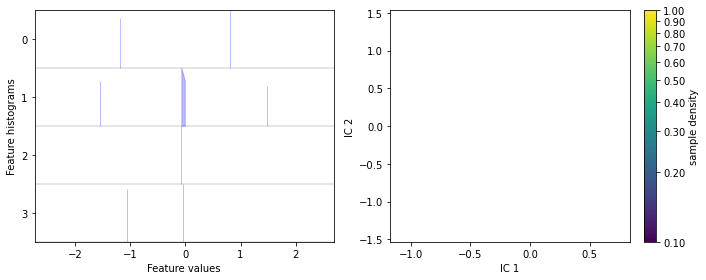

In [157]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    ls,
    ax=axes[0],
#     feature_labels=['IC1', 'IC2', 'IC3'],
    ylog=True, ignore_dim_warning=True)
pyemma.plots.plot_density(*ls[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()
# plt.savefig('tica2.png')